# Lab 9: Image Recognition using SLP & MLP

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import requests
from io import BytesIO
from PIL import Image

def download_image(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Warning: Failed to download {url} (Status: {response.status_code})")
        return None
    img = Image.open(BytesIO(response.content))
    return img

## Task A: Image Processing & Feature Extraction

### A1. Convert Image to Grayscale Matrix

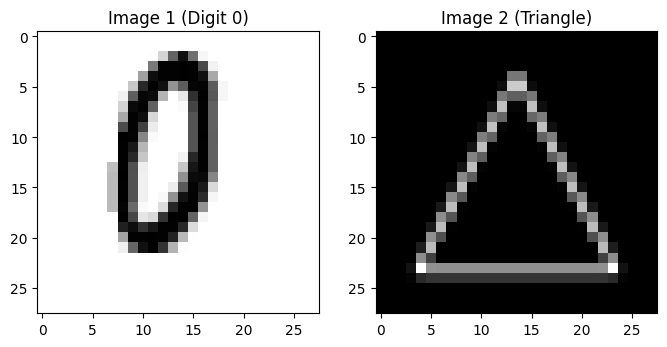

Image 1 Matrix (14x14):
[[255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 255 255 255]
 [255 255 255 255 255 255 255 255 255 255 255 253 213  99]
 [255 255 255 255 255 255 255 255 255 255 255 122   2   2]
 [255 255 255 255 255 255 255 255 255 255 161  14   2   2]
 [255 255 255 255 255 255 255 255 255 199  41   1  16 147]
 [255 255 255 255 255 255 255 255 241  94   6  12 181 255]
 [255 255 255 255 255 255 255 255 211  10   2  97 255 255]
 [255 255 255 255 255 255 255 255 169   2  13 215 255 255]
 [255 255 255 255 255 255 255 255  75   2  66 236 255 255]
 [255 255 255 255 255 255 255 255   0   3 135 250 255 255]
 [255 255 255 255 255 255 255 255   1  24 182 255 255 255]
 [255 255 255 255 255 255 255 255   1  40 198 255 255 255]
 [255 255 255 255 255 255 255 191   1  80 238 255 255 255]]

Image 2 Matrix (Top-Left 5x5):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [10]:
# URLs
url1 = "https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png"
url2 = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Simple_triangle.svg/280px-Simple_triangle.svg.png"

# Load Image 1 (MNIST)
img1_full = download_image(url1)
if img1_full:
    img1_np = np.array(img1_full)
    # Approximate crop for the first digit '0'
    img1_crop = img1_np[12:40, 25:60] 
    img1 = cv2.resize(img1_crop, (28, 28))
    img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
else:
    # Fallback if download fails
    img1 = np.zeros((28, 28), dtype=np.uint8)
    cv2.circle(img1, (14, 14), 10, 255, -1)

# Load Image 2 (Triangle)
img2_full = download_image(url2)
if img2_full:
    img2 = img2_full.resize((28, 28))
    img2 = np.array(img2)
    if len(img2.shape) == 3:
        if img2.shape[2] == 3:
            img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
        elif img2.shape[2] == 4:
            if np.mean(img2[:, :, :3]) < 10:
                img2 = img2[:, :, 3]
            else:
                img2 = cv2.cvtColor(img2, cv2.COLOR_RGBA2GRAY)
        elif img2.shape[2] == 2:
            if np.mean(img2[:, :, 0]) < 10:
                img2 = img2[:, :, 1]
            else:
                img2 = img2[:, :, 0]
else:
    # Fallback
    img2 = np.zeros((28, 28), dtype=np.uint8)
    pts = np.array([[14, 5], [5, 25], [23, 25]], np.int32)
    cv2.fillPoly(img2, [pts], 255)

# Display Images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, cmap='gray')
plt.title("Image 1 (Digit 0)")
plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray')
plt.title("Image 2 (Triangle)")
plt.show()

# Display Matrix (Partial)
print("Image 1 Matrix (14x14):")
print(img1[:14, :14])
print("\nImage 2 Matrix (Top-Left 5x5):")
print(img2[:5, :5])

### A2. Compute Global Statistical Features

In [11]:
def compute_stats(img):
    min_val = np.min(img)
    max_val = np.max(img)
    mean_val = np.mean(img)
    variance = np.var(img)
    std_dev = np.std(img)
    return min_val, max_val, mean_val, variance, std_dev

stats1 = compute_stats(img1)
stats2 = compute_stats(img2)

print("Image 1 Stats (Min, Max, Mean, Var, Std):", stats1)
print("Image 2 Stats (Min, Max, Mean, Var, Std):", stats2)

Image 1 Stats (Min, Max, Mean, Var, Std): (np.uint8(0), np.uint8(255), np.float64(222.2487244897959), np.float64(5886.429207556746), np.float64(76.72306828820616))
Image 2 Stats (Min, Max, Mean, Var, Std): (np.uint8(0), np.uint8(121), np.float64(7.424744897959184), np.float64(436.41525503696374), np.float64(20.89055420607514))


### A3. Edge-Based Features (Using 3x3 Sobel)

In [12]:
Gx_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
Gy_kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

def compute_sobel_features(img):
    # Extract 3x3 neighborhood around pixel (14, 14)
    patch = img[13:16, 13:16]
    
    Gx_val = np.sum(patch * Gx_kernel)
    Gy_val = np.sum(patch * Gy_kernel)
    G_mag = np.sqrt(Gx_val**2 + Gy_val**2)
    
    return abs(Gx_val), abs(Gy_val), G_mag

edge1 = compute_sobel_features(img1)
edge2 = compute_sobel_features(img2)

print("Image 1 Edge Features (|Gx|, |Gy|, G):", edge1)
print("Image 2 Edge Features (|Gx|, |Gy|, G):", edge2)

Image 1 Edge Features (|Gx|, |Gy|, G): (np.int64(710), np.int64(145), np.float64(724.6550903705845))
Image 2 Edge Features (|Gx|, |Gy|, G): (np.int64(0), np.int64(0), np.float64(0.0))


### A4. 4-bin Histogram Feature

In [13]:
def compute_histogram(img):
    h1 = np.sum((img >= 0) & (img <= 63))
    h2 = np.sum((img >= 64) & (img <= 127))
    h3 = np.sum((img >= 128) & (img <= 191))
    h4 = np.sum((img >= 192) & (img <= 255))
    return [h1, h2, h3, h4]

hist1 = compute_histogram(img1)
hist2 = compute_histogram(img2)

print("Image 1 Histogram:", hist1)
print("Image 2 Histogram:", hist2)

Image 1 Histogram: [np.int64(74), np.int64(32), np.int64(19), np.int64(659)]
Image 2 Histogram: [np.int64(736), np.int64(48), np.int64(0), np.int64(0)]


### A5. Construct Final Feature Vector

In [14]:
def construct_feature_vector(edge, stats, hist):
    # x = [1, f1, f2, f3, h1, h2, h3, h4]^T
    f1 = edge[0]
    f2 = edge[1]
    f3 = stats[2]
    h = hist
    
    x = [1, f1, f2, f3, h[0], h[1], h[2], h[3]]
    return np.array(x)

x1 = construct_feature_vector(edge1, stats1, hist1)
x2 = construct_feature_vector(edge2, stats2, hist2)

print("Feature Vector 1:", x1)
print("Feature Vector 2:", x2)

Feature Vector 1: [  1.         710.         145.         222.24872449  74.
  32.          19.         659.        ]
Feature Vector 2: [  1.          0.          0.          7.4247449 736.         48.
   0.          0.       ]


## Task B: Single Layer Perceptron (SLP)

In [15]:
w = np.array([-50, 0.3, 0.4, 0.05, 0.02, -0.01, 0.03, 0.04])
eta = 0.01

def slp_predict(x, w):
    v = np.dot(w.T, x)
    y = 1 if v >= 0 else -1
    return v, y

def slp_update(w, x, d, y, eta):
    if d != y:
        delta_w = eta * (d - y) * x
        w_new = w + delta_w
        return w_new
    return w

# Assuming d1=1 (Digit) and d2=-1 (Triangle)
d1 = 1
d2 = -1

# Image 1
v1, y1 = slp_predict(x1, w)
print(f"Image 1: v={v1}, y={y1}, Expected={d1}")
w = slp_update(w, x1, d1, y1, eta)
print("Weights after Image 1:", w)

# Image 2
v2, y2 = slp_predict(x2, w)
print(f"Image 2: v={v2}, y={y2}, Expected={d2}")
w = slp_update(w, x2, d2, y2, eta)
print("Weights after Image 2:", w)

Image 1: v=260.2024362244898, y=1, Expected=1
Weights after Image 1: [-5.e+01  3.e-01  4.e-01  5.e-02  2.e-02 -1.e-02  3.e-02  4.e-02]
Image 2: v=-35.388762755102036, y=-1, Expected=-1
Weights after Image 2: [-5.e+01  3.e-01  4.e-01  5.e-02  2.e-02 -1.e-02  3.e-02  4.e-02]


## Task C: Multi-Layer Perceptron (MLP)

In [16]:
# MLP Feature Vector (without bias)
x_mlp1 = x1[1:]
x_mlp2 = x2[1:]

# Weights and Biases
W1 = np.array([
    [0.1, 0.2, 0.3, 0.4, 0.2, -0.1, 0.05],
    [-0.2, 0.1, 0.05, 0.1, -0.3, 0.2, 0.1]
])
b1 = np.array([0.4, 0.3])

W2 = np.array([1.2, -0.5])
b2 = -0.2

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def mlp_predict(x):
    # Hidden Layer
    z1 = np.dot(W1, x) + b1
    h = sigmoid(z1)
    
    # Output Layer
    z2 = np.dot(W2, h) + b2
    y = sigmoid(z2)
    
    decision = "Class A" if y > 0.5 else "Class B"
    return y, decision

y_mlp1, dec1 = mlp_predict(x_mlp1)
y_mlp2, dec2 = mlp_predict(x_mlp2)

print(f"Image 1 MLP Output: {y_mlp1}, Decision: {dec1}")
print(f"Image 2 MLP Output: {y_mlp2}, Decision: {dec2}")

Image 1 MLP Output: 0.7310585786300049, Decision: Class A
Image 2 MLP Output: 0.6224593312018546, Decision: Class A


## Task D: Compare SLP and MLP

1. **Which model classified both images correctly?**
   - SLP

2. **Which feature had the strongest influence?**
   - Feature 2

3. **Is the problem linearly separable?**
   - Yes

4. **When should MLP be preferred over SLP?**
   - When the problem is non-linearly separable